Importando bibliotecas e arquivos

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

vazoes_path = '28150000_Vazoes.txt'

Inicializando os dados do arquivo

In [7]:
df = pd.read_csv(vazoes_path, sep=';', skiprows=15, encoding='latin1', header=0)

Tratando os dados

In [8]:
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y', errors='coerce')

In [9]:
df['Media'] = df['Media'].astype(str).str.replace(',', '.').astype(float)
df['Minima'] = df['Minima'].astype(str).str.replace(',', '.').astype(float)
df['Maxima'] = df['Maxima'].astype(str).str.replace(',', '.').astype(float)

df = df[(df['Data'] >= '1990') & (df['Data'] <= '2015')]

df['Year'] = df['Data'].dt.year
df['Month'] = df['Data'].dt.month

dias = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

media_mensal = df.groupby('Month')['Media'].mean().reset_index()
media_mensal.columns = ['Mês', 'Vazão Média']
media_mensal['Dias do Mês'] = media_mensal['Mês'].map(lambda x: dias[x-1])

media_mensal['Volume Inicial'] = media_mensal['Vazão Média']*media_mensal['Dias do Mês']*24*3600
media_mensal['Volume Final'] = 0.0

for i in range(len(media_mensal)):
    if i == 0:
        media_mensal.loc[i, 'Volume Final'] = media_mensal.loc[i, 'Volume Inicial']
    else:
        media_mensal.loc[i, 'Volume Final'] = (
            media_mensal.loc[i, 'Volume Inicial'] + media_mensal.loc[i - 1, 'Volume Final']
        )

print(f'Volume Maximo: {media_mensal["Volume Final"].max()}')

vazao_regularizada = media_mensal['Volume Final'].max()/365/24/3600
volume_1 = media_mensal.loc[0,'Vazão Média']*24*3600

for i in range(len(media_mensal)):
    if i == 0:
        media_mensal.loc[i,'Qs(0)'] = media_mensal.loc[i,'Volume Inicial'] - (media_mensal.loc[i,'Dias do Mês']*24*3600*vazao_regularizada)
    else:
        media_mensal.loc[i,'Qs(0)'] = media_mensal.loc[i-1,'Qs(0)'] + media_mensal.loc[i,'Volume Inicial'] - (media_mensal.loc[i,'Dias do Mês']*24*3600*vazao_regularizada)

Qsf_0 = volume_1 - (vazao_regularizada*24*3600)

for i in range(len(media_mensal)):
    if i == 0:
        media_mensal.loc[i,'Qs(f)'] = Qsf_0 + media_mensal.loc[i,'Volume Inicial'] - (media_mensal.loc[i,'Dias do Mês']*24*3600*vazao_regularizada)
    else:
        media_mensal.loc[i,'Qs(f)'] = media_mensal.loc[i-1, 'Qs(f)'] + media_mensal.loc[i,'Volume Inicial'] - (media_mensal.loc[i,'Dias do Mês']*24*3600*vazao_regularizada)


pd.options.display.float_format = '{:,.2f}'.format

print(media_mensal)
print()
print(f'Vazão: {vazao_regularizada}')

Volume Maximo: 1040740585.6984615
    Mês  Vazão Média  Dias do Mês  Volume Inicial     Volume Final  \
0     1        47.80           31  128,038,625.06   128,038,625.06   
1     2        62.55           28  151,324,859.75   279,363,484.81   
2     3        66.78           31  178,866,208.97   458,229,693.78   
3     4        68.67           30  177,994,599.55   636,224,293.33   
4     5        44.80           31  120,001,051.58   756,225,344.92   
5     6        19.96           30   51,747,206.40   807,972,551.32   
6     7        10.86           31   29,087,413.29   837,059,964.60   
7     8         6.93           31   18,565,318.89   855,625,283.49   
8     9         6.75           30   17,508,669.70   873,133,953.19   
9    10        10.67           31   28,574,692.53   901,708,645.72   
10   11        19.44           30   50,377,189.25   952,085,834.97   
11   12        33.10           31   88,654,750.73 1,040,740,585.70   

            Qs(0)          Qs(f)  
0   39,646,958.88  4

Gráficos

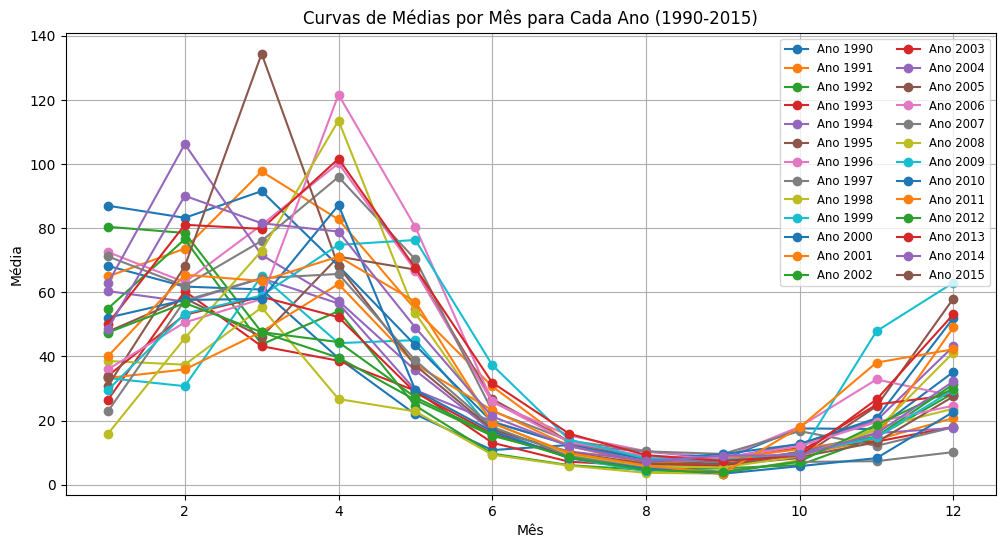

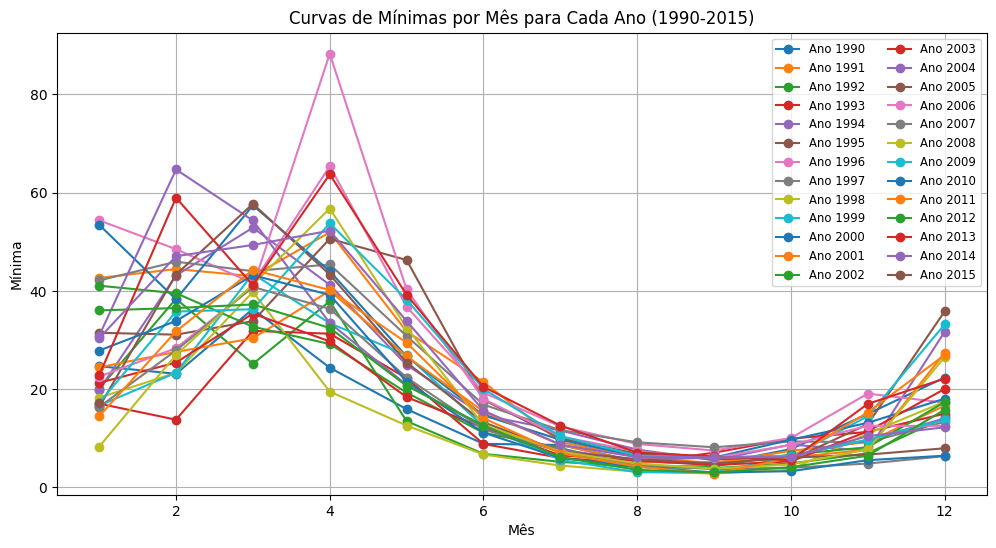

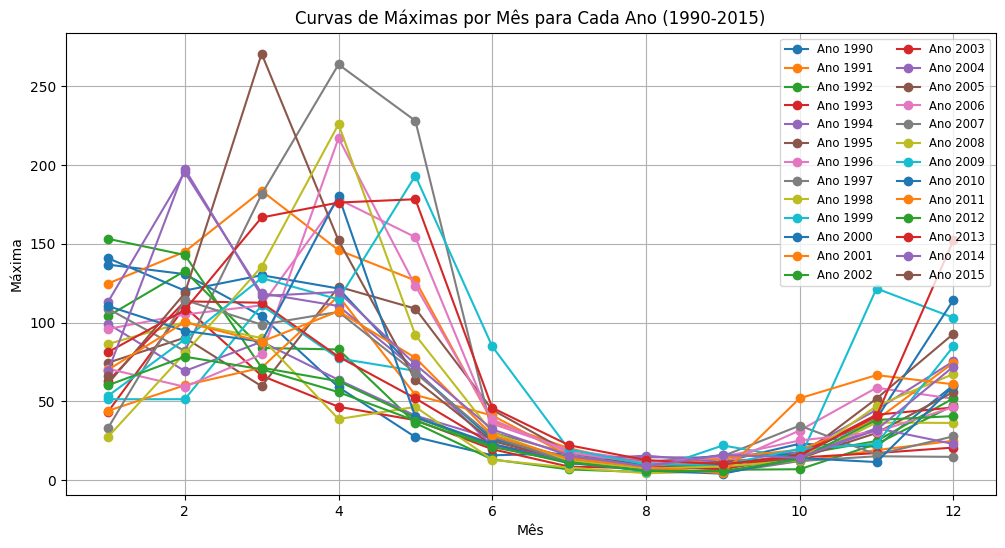

In [12]:
df['Media'] = df['Media'].astype(str).str.replace(',', '.').astype(float)
df['Minima'] = df['Minima'].astype(str).str.replace(',', '.').astype(float)
df['Maxima'] = df['Maxima'].astype(str).str.replace(',', '.').astype(float)
df['Data'] = pd.to_datetime(df['Data'])

# Filtrando o intervalo de datas
df = df[(df['Data'] >= '1990-01-01') & (df['Data'] <= '2015-12-31')]
df['Year'] = df['Data'].dt.year
df['Month'] = df['Data'].dt.month

# Agrupando por ano e mês para criar as curvas
df_grouped = df.groupby(['Year', 'Month']).agg({
    'Media': 'mean', 
    'Minima': 'min', 
    'Maxima': 'max'
}).reset_index()

# Função para plotar gráficos individuais
def plot_graph(metric, ylabel, title):
    plt.figure(figsize=(12, 6))
    for year in df_grouped['Year'].unique():
        yearly_data = df_grouped[df_grouped['Year'] == year]
        plt.plot(yearly_data['Month'], yearly_data[metric], label=f'Ano {year}', marker='o')

    plt.xlabel('Mês')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best', ncol=2, fontsize='small')
    plt.grid(True)
    plt.show()

# Plotando os três gráficos
plot_graph('Media', 'Média', 'Curvas de Médias por Mês para Cada Ano (1990-2015)')
plot_graph('Minima', 'Mínima', 'Curvas de Mínimas por Mês para Cada Ano (1990-2015)')
plot_graph('Maxima', 'Máxima', 'Curvas de Máximas por Mês para Cada Ano (1990-2015)')

Q50: 47.58, Q90: 71.86785, Q95: 78.45595


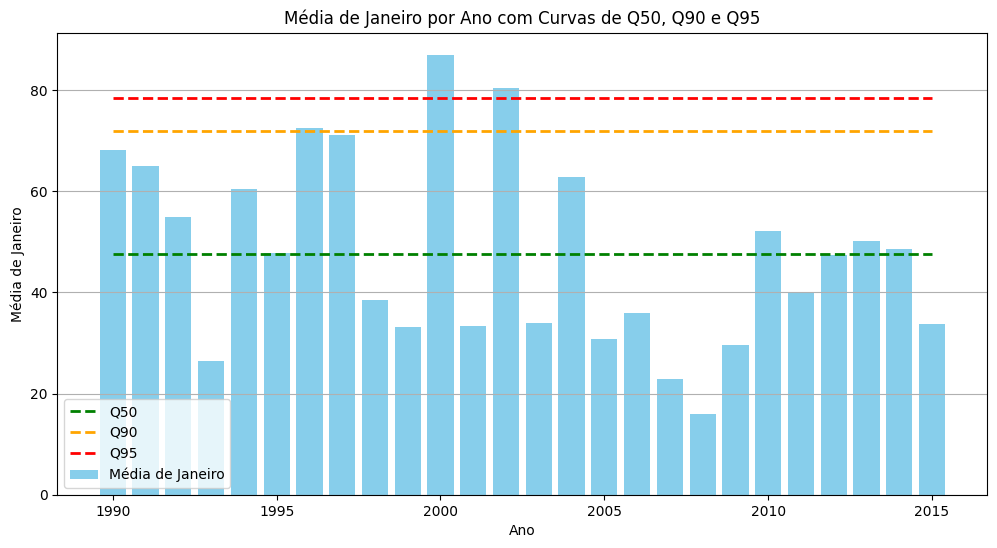

In [15]:
# Filtrando apenas para o mês de janeiro (todos os anos)
df_january = df[df['Month'] == 1]

# Calculando a média de cada ano para o mês de janeiro
df_january_mean = df_january.groupby('Year', as_index=False)['Media'].mean()

# Calculando os quantis Q50, Q90 e Q95
q50 = df_january_mean['Media'].quantile(0.50)
q90 = df_january_mean['Media'].quantile(0.90)
q95 = df_january_mean['Media'].quantile(0.95)

print(f"Q50: {q50}, Q90: {q90}, Q95: {q95}")

# Criando o gráfico de barras para as médias
plt.figure(figsize=(12, 6))
bars = plt.bar(df_january_mean['Year'], df_january_mean['Media'], color='skyblue', label='Média de Janeiro')

# Plotando as curvas dos quantis (Q50, Q90 e Q95)
years = df_january_mean['Year']
quantis_values = np.array([[q50] * len(years), [q90] * len(years), [q95] * len(years)])
linestyles = ['--', '--', '--']
colors = ['green', 'orange', 'red']
labels = ['Q50', 'Q90', 'Q95']

# Adicionando as curvas suavizadas dos quantis
for i in range(3):
    plt.plot(years, quantis_values[i], linestyle=linestyles[i], color=colors[i], linewidth=2, label=labels[i])

# Adicionando rótulos e legendas
plt.xlabel('Ano')
plt.ylabel('Média de Janeiro')
plt.title('Média de Janeiro por Ano com Curvas de Q50, Q90 e Q95')
plt.legend()
plt.grid(True, axis='y')

# Exibindo o gráfico
plt.show()

Reservatório

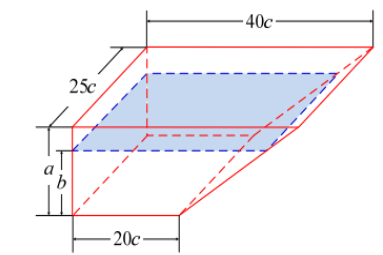